## Image classification with deep learning methods.

-- Description --

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.
In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.
Although you used your computer successfuly it is highly recommended to give a try to Google Colab environment.


In [46]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install medmnist
import medmnist
from medmnist import *

In [41]:
# Parameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
lr = 0.0001
DOWNLOAD_OK = True
data_flag = 'bloodmnist'
#data_flag = 'pneumomnist'
im_size = 64
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
num_classes = len(info['label'])
N_IMAGES = 1000
data_labels = info['label']

# Tupla que contiene los valores asociados a los parámetros mostrados anteriormente,
# con el fin de mejorar la organización de dichos parámetros.
parameters = {"num_epochs": NUM_EPOCHS, "batch_size": BATCH_SIZE, "lr": lr, "download_ok": DOWNLOAD_OK,
              "data_flag": data_flag, "im_size": im_size,"info_task": task, "n_channels": n_channels,
              "num_classes": num_classes,"n_images":N_IMAGES, "data_labels": data_labels}

# Preprocesado de datos mediante la definición de la transformación de datos
def preprocessing_data(parameters):
  data_transform = transforms.Compose([
    transforms.Resize((parameters["im_size"],parameters["im_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
  ])

  full_train_dataset = BloodMNIST(split="train", transform=data_transform, download=True)
  full_valid_dataset = BloodMNIST(split="val", transform=data_transform, download=True)
  full_test_dataset = BloodMNIST(split="test", transform=data_transform, download=True)

  idx_train = np.random.choice(len(full_train_dataset),size=1000,replace=False)
  train_dataset = [full_train_dataset[i] for i in idx_train]

  idx_valid = np.random.choice(len(full_valid_dataset),size=300,replace=False)
  valid_dataset = [full_valid_dataset[i] for i in idx_valid]

  idx_test = np.random.choice(len(full_test_dataset),size=600,replace=False)
  test_dataset = [full_test_dataset[i] for i in idx_test]

  train_loader = data.DataLoader(dataset=train_dataset, batch_size=parameters["batch_size"], shuffle=True)
  valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=parameters["batch_size"], shuffle=False)
  test_loader = data.DataLoader(dataset=test_dataset, batch_size=parameters["batch_size"], shuffle=True)

  return train_loader, valid_loader, test_loader, train_dataset, valid_dataset, test_dataset

train_loader,valid_loader,test_loader,train_dataset,valid_dataset,test_dataset = preprocessing_data(parameters)

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


In [ ]:
## Your code

# Función que permite visualizar los aspectos fundamentales sobre cada
# dataset que se haya descargado/cargado previamente.
def dataset_visualizer(dataset,length_montage):
  for i in range(0,length_montage*length_montage):
    img = dataset[i][0]
    label = str(dataset[i][1]).replace('[','').replace(']','')
    figure = plt.figure(figsize=(2,2))
    plt.imshow(img.permute(1,2,0))
    plt.title(data_labels[label])
    plt.axis("off")
  plt.show()

# Visualizador de las imágenes a través de un pipeline DataLoader
def dataloader_visualizer(data_loader,num_batches):
  for batch_idx, (features, labels) in enumerate(data_loader):
      if batch_idx >= num_batches:
        break
      for i in range(len(features)):
        img = features[i].squeeze()
        label = str(labels[i]).replace('tensor([','').replace('])','')
        plt.figure(figsize=(2,2))
        plt.title(label)
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')
        plt.show()

def net_model_visualizer(net_model):
  print(net_model)
  print('Total Parameters:',
       sum([torch.numel(p) for p in net_model.parameters()])
  )
  print('Trainable Parameters:',
       sum([torch.numel(p) for p in net_model.parameters() if p.requires_grad])
  )
dataset_visualizer(train_dataset,5)

#dataloader_visualizer(train_loader,1)
#dataloader_visualizer(valid_loader,1)
#dataloader_visualizer(test_loader,1)

In [47]:
# Define a simple CNN model

def convolution(in_channels,out_channels):
  layer = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU(),
      nn.MaxPool2d(2,2)
  )
  return layer

def double_convultion(in_channels,out_channels):
  conv_op = nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,3),
      nn.ReLU()
  )
  return conv_op

"""
class Net(nn.Module):
    def __init__(self, parameters):
        super(Net, self).__init__()

        self.layer1 = convolution(parameters["n_channels"],8)
        self.layer2 = convolution(8,16)
        self.layer3 = convolution(16,32)
        self.layer4 = convolution(32,64)

        self.fc1 = nn.Linear(64,32)
        self.drop1 = nn.Dropout(0.33)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32,parameters["num_classes"])

        #End your code

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x,1).reshape(x.size(0),-1)

        x = self.fc1(x)
        x = self.drop1(x)
        x = self.relu1(x)
        x = self.fc2(x)

        return x
"""
class UNetCNN(nn.Module):
  def __init__(self,parameters):
    super(UNetCNN,self).__init__()

    self.max_pool2d = nn.MaxPool2d(2,2)

    self.down_conv1 = double_convultion(parameters["n_channels"],8)
    self.down_conv2 = double_convultion(8,16)
    self.down_conv3 = double_convultion(16,32)
    self.down_conv4 = double_convultion(32,64)
    self.down_conv5 = double_convultion(64,128)

    self.up_trans1 = nn.ConvTranspose2d(128,64,2,2)
    self.up_conv1 = double_convultion(128,64)
    self.up_trans2 = nn.ConvTranspose2d(64,32,2,2)
    self.up_conv2 = double_convultion(64,32)
    self.up_trans3 = nn.ConvTranspose2d(32,16,2,2)
    self.up_conv3 = double_convultion(32,16)
    self.up_trans4 = nn.ConvTranspose2d(16,8,2,2)
    self.up_conv4 = double_convultion(16,8)

    self.final_layer = nn.Conv2d(8,parameters["num_classes"],1)

  def forward(self,x):
    print(x.shape)
    down1 = self.down_conv1(x)
    print(down1.shape)
    down2 = self.max_pool2d(down1)
    print(down2.shape)
    down3 = self.down_conv2(down2)
    print(down3.shape)
    down4 = self.max_pool2d(down3)
    print(down4.shape)
    down5 = self.down_conv3(down4)
    print(down5.shape)
    down6 = self.max_pool2d(down5)
    print(down6.shape)
    down7 = self.down_conv4(down6)
    print(down7.shape)
    down8 = self.max_pool2d(down7)
    print(down8.shape)
    down9 = self.down_conv5(down8)
    print(down9.shape)

    up1 = self.up_trans1(down9)
    print(up1.shape)
    x = self.up_conv1(torch.cat([down7,up1],1))

    up2 = self.up_trans2(x)
    print(up2.shape)
    x = self.up_conv2(torch.cat([down5,up2],1))

    up3 = self.up_trans3(x)
    print(up3.shape)
    x = self.up_conv3(torch.cat([down3,up3],1))

    up4 = self.up_trans4(x)
    print(up4.shape)
    x = self.up_conv4(torch.cat([down1,up4],1))

    final_layer = self.final_layer(x)
    return final_layer

"""
class ResNet18(nn.Module):
  def __init__(self,parameters):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)
    self.bn1 = nn.BatchNorm2d(64)
    self.maxpool = nn.MaxPool2d(3,2,1)

    self.conv2_block1 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv2_block2 = nn.Sequential(
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64,64,3,1,1),
        nn.BatchNorm2d(64)
    )

    self.conv3_block1 = nn.Sequential(
        nn.Conv2d(64,128,3,2,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv3_block2 = nn.Sequential(
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.Conv2d(128,128,3,1,1),
        nn.BatchNorm2d(128)
    )

    self.conv4_block1 = nn.Sequential(
        nn.Conv2d(128,256,3,2,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv4_block2 = nn.Sequential(
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.Conv2d(256,256,3,1,1),
        nn.BatchNorm2d(256)
    )

    self.conv5_block1 = nn.Sequential(
        nn.Conv2d(256,512,3,2,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.conv5_block2 = nn.Sequential(
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.Conv2d(512,512,3,1,1),
        nn.BatchNorm2d(512)
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(512,parameters["num_classes"])

  def forward(self,x):
    print(x.shape)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool(x)

    print(x.shape)
    x = self.conv2_block1(x)
    x = self.conv2_block2(x)
    x = self.conv3_block1(x)
    x = self.conv3_block2(x)
    x = self.conv4_block1(x)
    x = self.conv4_block2(x)
    x = self.conv5_block1(x)
    x = self.conv5_block2(x)

    x = self.avgpool(x)
    x = self.fc(x)

    return x
"""

'\nclass ResNet18(nn.Module):\n  def __init__(self,parameters):\n    super(ResNet18, self).__init__()\n\n    self.conv1 = nn.Conv2d(parameters["n_channels"],64,7,2,3)\n    self.bn1 = nn.BatchNorm2d(64)\n    self.maxpool = nn.MaxPool2d(3,2,1)\n\n    self.conv2_block1 = nn.Sequential(\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64),\n        nn.ReLU(True),\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64)\n    )\n\n    self.conv2_block2 = nn.Sequential(\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64),\n        nn.ReLU(True),\n        nn.Conv2d(64,64,3,1,1),\n        nn.BatchNorm2d(64)\n    )\n\n    self.conv3_block1 = nn.Sequential(\n        nn.Conv2d(64,128,3,2,1),\n        nn.BatchNorm2d(128),\n        nn.ReLU(True),\n        nn.Conv2d(128,128,3,1,1),\n        nn.BatchNorm2d(128)\n    )\n\n    self.conv3_block2 = nn.Sequential(\n        nn.Conv2d(128,128,3,1,1),\n        nn.BatchNorm2d(128),\n        nn.ReLU(True),\n        nn.Conv2d(128,128,3,1,1),

100%|██████████| 10/10 [00:00<00:00, 35.86it/s]
<ipython-input-48-9f035756d4e1>:76: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


Accuracy: 0.09333333333333334
AUC: 0.4826878656813822
F1 Score: nan
Confusion Matrix:
tensor([[28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [56.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [43.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


100%|██████████| 10/10 [00:00<00:00, 49.74it/s]


Accuracy: 0.14333333333333334
AUC: 0.49747633696338794
F1 Score: 3.2593220338983047
Confusion Matrix:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0., 28.,  0.],
        [15.,  0.,  0.,  0.,  0.,  0., 41.,  0.],
        [ 8.,  0.,  0.,  0.,  0.,  0., 20.,  0.],
        [ 2.,  0.,  0.,  0.,  0.,  0., 41.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.],
        [ 9.,  0.,  0.,  0.,  0.,  0., 19.,  0.],
        [12.,  0.,  0.,  0.,  0.,  0., 43.,  0.],
        [41.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


100%|██████████| 10/10 [00:00<00:00, 50.83it/s]


Accuracy: 0.18333333333333332
AUC: 0.48409669542395506
F1 Score: 4.505204718945177
Confusion Matrix:
tensor([[ 0.,  0.,  0.,  0.,  0.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 56.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 43.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 41.,  0.]])


100%|██████████| 10/10 [00:00<00:00, 50.37it/s]


Accuracy: 0.09666666666666666
AUC: 0.4986333158016026
F1 Score: 2.48767697954903
Confusion Matrix:
tensor([[ 0., 10.,  0.,  0.,  0.,  0., 18.,  0.],
        [ 0., 27.,  0.,  0.,  0.,  0., 29.,  0.],
        [ 0., 25.,  0.,  0.,  0.,  0.,  3.,  0.],
        [ 0., 16.,  0.,  0.,  0.,  0., 27.,  0.],
        [ 0., 21.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0.,  0.,  0.,  0., 26.,  0.],
        [ 0., 53.,  0.,  0.,  0.,  0.,  2.,  0.],
        [ 0., 41.,  0.,  0.,  0.,  0.,  0.,  0.]])


100%|██████████| 10/10 [00:00<00:00, 51.80it/s]


Accuracy: 0.23333333333333334
AUC: 0.5176196259068158
F1 Score: 1.7951482479784366
Confusion Matrix:
tensor([[ 0., 13.,  0., 15.,  0.,  0.,  0.,  0.],
        [ 0., 53.,  0.,  3.,  0.,  0.,  0.,  0.],
        [ 0., 25.,  0.,  3.,  0.,  0.,  0.,  0.],
        [ 0., 26.,  0., 17.,  0.,  0.,  0.,  0.],
        [ 0., 21.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 15.,  0., 13.,  0.,  0.,  0.,  0.],
        [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 41.,  0.,  0.,  0.,  0.,  0.,  0.]])


100%|██████████| 10/10 [00:00<00:00, 48.17it/s]


Accuracy: 0.3233333333333333
AUC: 0.5522888972378074
F1 Score: 3.743011280039235
Confusion Matrix:
tensor([[ 0.,  0.,  0., 28.,  0.,  0.,  0.,  0.],
        [ 0., 14.,  0., 22.,  0.,  0., 20.,  0.],
        [ 0., 22.,  0.,  6.,  0.,  0.,  0.,  0.],
        [ 0.,  4.,  0., 39.,  0.,  0.,  0.,  0.],
        [ 0., 10.,  0., 11.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0., 37.,  0., 13.,  0.,  0.,  5.,  0.],
        [ 0.,  2.,  0.,  0.,  0.,  0.,  0., 39.]])


100%|██████████| 10/10 [00:00<00:00, 52.09it/s]


Accuracy: 0.38
AUC: 0.5929937174835096
F1 Score: 4.225108225108225
Confusion Matrix:
tensor([[ 0.,  0.,  0., 25.,  0.,  0.,  3.,  0.],
        [ 0.,  6.,  0., 15.,  0.,  0., 34.,  1.],
        [ 0., 18.,  0.,  6.,  0.,  0.,  2.,  2.],
        [ 0.,  2.,  0., 37.,  0.,  0.,  4.,  0.],
        [ 0.,  7.,  0.,  5.,  0.,  0.,  9.,  0.],
        [ 0.,  0.,  0., 24.,  0.,  0.,  4.,  0.],
        [ 0., 20.,  0.,  5.,  0.,  0., 30.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 52.71it/s]


Accuracy: 0.33
AUC: 0.6707105256055792
F1 Score: 3.8598540145985405
Confusion Matrix:
tensor([[ 0.,  0.,  0., 28.,  0.,  0.,  0.,  0.],
        [ 0., 12.,  0., 39.,  0.,  0.,  4.,  1.],
        [ 0., 16.,  0.,  6.,  0.,  0.,  0.,  6.],
        [ 0.,  2.,  0., 41.,  0.,  0.,  0.,  0.],
        [ 0., 10.,  0., 11.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0., 36.,  0., 14.,  0.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 36.50it/s]


Accuracy: 0.41
AUC: 0.7281106434618396
F1 Score: 4.519491525423729
Confusion Matrix:
tensor([[ 0.,  0.,  0., 28.,  0.,  0.,  0.,  0.],
        [ 0.,  2.,  0., 45.,  0.,  0.,  8.,  1.],
        [ 0.,  6.,  0.,  6.,  0.,  0., 10.,  6.],
        [ 0.,  1.,  0., 41.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., 13.,  0.,  0.,  8.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0., 16.,  0.,  0., 39.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 50.14it/s]


Accuracy: 0.43333333333333335
AUC: 0.7694907008470153
F1 Score: 4.527509449811004
Confusion Matrix:
tensor([[ 0.,  0.,  0., 28.,  0.,  0.,  0.,  0.],
        [ 0.,  9.,  0., 38.,  0.,  0.,  8.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  2.,  0.],
        [ 0.,  1.,  0., 11.,  0.,  0.,  9.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0.,  2.,  0., 13.,  0.,  0., 40.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 52.04it/s]


Accuracy: 0.43333333333333335
AUC: 0.8130944848432128
F1 Score: 4.5612903225806445
Confusion Matrix:
tensor([[ 0.,  0.,  0., 27.,  0.,  0.,  1.,  0.],
        [ 0.,  3.,  0., 30.,  0.,  0., 22.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 15.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  9.,  0.,  0., 46.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 51.35it/s]


Accuracy: 0.46
AUC: 0.8204123739850561
F1 Score: 4.558512885509084
Confusion Matrix:
tensor([[ 0.,  1.,  0., 27.,  0.,  0.,  0.,  0.],
        [ 0., 15.,  0., 31.,  0.,  0.,  9.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  3.,  0., 38.,  0.,  0.,  2.,  0.],
        [ 0.,  7.,  0.,  4.,  0.,  0., 10.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  2.,  0.,  9.,  0.,  0., 44.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 51.75it/s]


Accuracy: 0.43666666666666665
AUC: 0.8450394775041108
F1 Score: 4.566098945660989
Confusion Matrix:
tensor([[ 0.,  0.,  0., 27.,  0.,  0.,  1.,  0.],
        [ 0.,  5.,  0., 30.,  0.,  0., 20.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  2.,  0., 39.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 15.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  9.,  0.,  0., 46.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 46.00it/s]


Accuracy: 0.44333333333333336
AUC: 0.8597354590661419
F1 Score: 4.575843838958925
Confusion Matrix:
tensor([[ 0.,  0.,  0., 27.,  0.,  0.,  1.,  0.],
        [ 0.,  6.,  0., 31.,  0.,  0., 18.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  7.,  0.,  0., 14.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  9.,  0.,  0., 46.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 50.18it/s]


Accuracy: 0.46
AUC: 0.8666381902765392
F1 Score: 4.5781119465329985
Confusion Matrix:
tensor([[ 0.,  2.,  0., 26.,  0.,  0.,  0.,  0.],
        [ 0., 13.,  0., 30.,  0.,  0., 12.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  2.,  0., 39.,  0.,  0.,  2.,  0.],
        [ 0.,  4.,  0.,  6.,  0.,  0., 11.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  1.,  0.,  9.,  0.,  0., 45.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 48.68it/s]


Accuracy: 0.48333333333333334
AUC: 0.8670523815518447
F1 Score: 4.586826347305389
Confusion Matrix:
tensor([[ 0.,  3.,  0., 25.,  0.,  0.,  0.,  0.],
        [ 0., 23.,  0., 24.,  0.,  0.,  8.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  6.,  0., 35.,  0.,  0.,  2.,  0.],
        [ 0.,  8.,  0.,  3.,  0.,  0., 10.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  4.,  0.,  5.,  0.,  0., 46.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 37.35it/s]


Accuracy: 0.5
AUC: 0.8698084072715715
F1 Score: 4.526730937773882
Confusion Matrix:
tensor([[ 0.,  4.,  0., 24.,  0.,  0.,  0.,  0.],
        [ 0., 31.,  0., 17.,  0.,  0.,  7.,  1.],
        [ 0.,  1.,  0.,  5.,  0.,  0., 14.,  8.],
        [ 0.,  6.,  0., 35.,  0.,  0.,  2.,  0.],
        [ 0., 11.,  0.,  2.,  0.,  0.,  8.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0., 10.,  0.,  2.,  0.,  0., 43.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 50.63it/s]


Accuracy: 0.48333333333333334
AUC: 0.8819068303145498
F1 Score: 4.613132580510246
Confusion Matrix:
tensor([[ 0.,  3.,  0., 25.,  0.,  0.,  0.,  0.],
        [ 0., 21.,  0., 19.,  0.,  0., 15.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  6.,  0., 35.,  0.,  0.,  2.,  0.],
        [ 0.,  4.,  0.,  3.,  0.,  0., 14.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  3.,  0.,  4.,  0.,  0., 48.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 50.28it/s]


Accuracy: 0.47
AUC: 0.8842189980596
F1 Score: 4.59616985845129
Confusion Matrix:
tensor([[ 0.,  1.,  0., 27.,  0.,  0.,  0.,  0.],
        [ 0., 14.,  0., 29.,  0.,  0., 12.,  1.],
        [ 0.,  0.,  0.,  6.,  0.,  0., 14.,  8.],
        [ 0.,  1.,  0., 40.,  0.,  0.,  2.,  0.],
        [ 0.,  3.,  0.,  8.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  9.,  0.,  0., 46.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


100%|██████████| 10/10 [00:00<00:00, 51.66it/s]


Accuracy: 0.5066666666666667
AUC: 0.8828728365584549
F1 Score: 4.56682629516761
Confusion Matrix:
tensor([[ 0.,  3.,  0., 25.,  0.,  0.,  0.,  0.],
        [ 0., 32.,  0., 16.,  0.,  0.,  7.,  1.],
        [ 0.,  1.,  0.,  5.,  0.,  0., 14.,  8.],
        [ 0.,  7.,  0., 34.,  0.,  0.,  2.,  0.],
        [ 0.,  9.,  0.,  3.,  0.,  0.,  9.,  0.],
        [ 0.,  1.,  0., 25.,  0.,  0.,  2.,  0.],
        [ 0.,  8.,  0.,  2.,  0.,  0., 45.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 41.]])


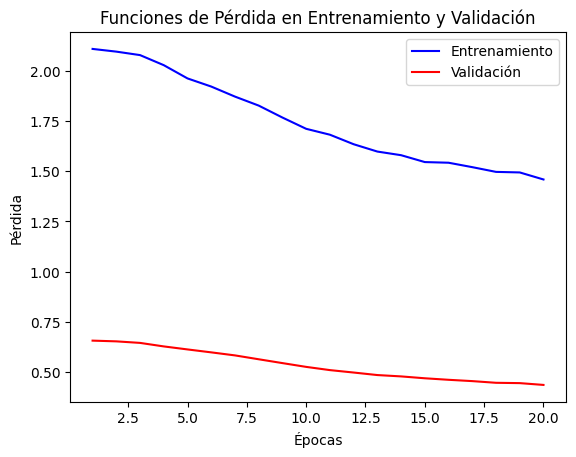

In [48]:
# Train the model
def train_epoch(model,train_loader,optimizer,criterion,epoch,parameters):
    train_loss_epoch = 0

    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(train_loader),total=len(train_loader)):
        outputs = model(X_batch)
        y_batch = y_batch.squeeze().long()

        loss = criterion(outputs,y_batch)

        train_loss_epoch += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_epoch /= parameters["batch_size"]

    return train_loss_epoch

def validate_epoch(model,valid_loader,criterion,epoch,parameters):
    valid_loss_epoch = 0

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    with torch.no_grad():
      for batch_idx, (X_batch, y_batch) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
          outputs = model(X_batch)
          y_batch = y_batch.squeeze().long()

          loss = criterion(outputs,y_batch)

          valid_loss_epoch += loss.item()

          outputs = outputs.softmax(1)
          y_batch = y_batch.resize_(len(y_batch),1)

          y_true = torch.cat((y_true, y_batch),0)
          y_score = torch.cat((y_score, outputs),0)

      y_true = y_true.numpy()
      y_score = y_score.detach().numpy()

      y_labels = np.argmax(y_score,1)[...,np.newaxis]

      acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)
      auc = roc_auc_score(y_true,y_score,multi_class='ovr')
      f1 = f1_score_function(y_true,y_labels)
      matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])

      print("Accuracy:", acc)
      print("AUC:", auc)
      print("F1 Score:", f1.item())
      print("Confusion Matrix:")
      print(matrix)

      valid_loss_epoch /= parameters["batch_size"]

      return valid_loss_epoch

def loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch):
  plt.plot(epochs, train_loss_epoch, 'b', label='Entrenamiento')
  plt.plot(epochs, valid_loss_epoch, 'r', label='Validación')
  plt.title('Funciones de Pérdida en Entrenamiento y Validación')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def f1_score_function(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  f1 = 2 * (precision * recall) / (precision + recall)

  return f1

def confusion_matrix(y_true,y_pred,num_classes):
  y_true = y_true.long()
  y_pred = y_pred.long()

  confusion_matrix = torch.zeros(num_classes,num_classes)

  for t, p in zip(y_true.view(-1), y_pred.view(-1)):
      confusion_matrix[t, p] += 1

  return confusion_matrix

def model_training(model,optimizer,criterion,train_loader,valid_loader,parameters):
  train_loss_epoch = []
  valid_loss_epoch = []
  epochs = range(1,parameters["num_epochs"]+1)

  for epoch in range(parameters["num_epochs"]):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,criterion,epoch,parameters)
    model.eval()
    valid_loss = validate_epoch(model,valid_loader,criterion,epoch,parameters)

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)

  loss_function_graphics(epochs,train_loss_epoch,valid_loss_epoch)


model = Net(parameters)
#model = ResNet18(parameters)
#model = UNetCNN(parameters)

#net_model_visualizer(model)
optimizer = torch.optim.Adam(model.parameters(),lr=parameters["lr"])
criterion = nn.CrossEntropyLoss()

model_training(model,optimizer,criterion,train_loader,valid_loader,parameters)

#Evaluation

Finally, implement the evaluation of the object clasification task. You can implement any metric you want, though the most common are accuracy and AUC (one class against all for the multiclass task). You can use torch.no_grad() for speeding up predictions when no gradients are needed.

How do you compare with the MedMNIST benchmarks?

In [49]:
def model_final_test(model,test_loader,criterion,parameters):
  model.eval()

  test_loss = 0
  y_true = torch.tensor([])
  y_score = torch.tensor([])

  with torch.no_grad():
    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(test_loader),total=len(test_loader)):
      outputs = model(X_batch)
      y_batch = y_batch.squeeze().long()

      loss = criterion(outputs,y_batch)

      test_loss += loss.item()

      outputs = outputs.softmax(1)
      y_batch = y_batch.resize_(len(y_batch),1)

      y_true = torch.cat((y_true, y_batch),0)
      y_score = torch.cat((y_score, outputs),0)

    y_true = y_true.numpy()
    y_score = y_score.detach().numpy()

    y_labels = np.argmax(y_score,1)[...,np.newaxis]

    test_acc = np.sum(y_true == y_labels) / np.sum(y_true == y_true)
    test_auc = roc_auc_score(y_true,y_score,multi_class='ovr')
    test_f1 = f1_score_function(y_true,y_labels)
    test_matrix = confusion_matrix(torch.from_numpy(y_true),torch.from_numpy(y_labels),parameters["num_classes"])
    test_loss /= parameters["batch_size"]

    print("Accuracy:", test_acc)
    print("AUC:", test_auc)
    print("F1 Score:", test_f1.item())
    print("Loss Function",test_loss)
    print("Confusion Matrix:")
    print(test_matrix)

model_final_test(model,test_loader,criterion,parameters)

100%|██████████| 19/19 [00:00<00:00, 43.76it/s]


Accuracy: 0.49666666666666665
AUC: 0.8725956073533894
F1 Score: 4.459995639851755
Loss Function 0.8099619559943676
Confusion Matrix:
tensor([[ 0.,  1.,  0., 43.,  0.,  0.,  1.,  0.],
        [ 0., 59.,  0., 36.,  0.,  0., 25.,  3.],
        [ 0.,  3.,  0.,  6.,  0.,  0., 30., 16.],
        [ 0., 20.,  0., 72.,  0.,  0.,  3.,  0.],
        [ 0., 20.,  0.,  7.,  0.,  0., 12.,  0.],
        [ 0.,  4.,  0., 47.,  0.,  0.,  1.,  0.],
        [ 0., 20.,  0.,  4.,  0.,  0., 83.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 84.]])
